# Test MODFLOW API

In [1]:
from pathlib import Path

import flopy
import pastas as ps
from pastas.timer import SolveTimer

from pastas_plugins import modflow as ppmf

bindir = Path("bin")
if not (bindir / "mf6").exists():
    bindir.mkdir(parents=True, exist_ok=True)
    flopy.utils.get_modflow(bindir, repo="modflow6")

dll = "bin/libmf6.so"

ps.set_use_cache(True)

## Load Data

In [2]:
ds = ps.load_dataset("collenteur_2019")
head = ds["head"].squeeze().dropna()
prec = ds["rain"].squeeze().dropna().resample("D").asfreq().fillna(0.0)
evap = ds["evap"].squeeze().dropna()

prec = prec.loc["2002-11-01":]
evap = evap.loc["2002-11-01":]

## MODFLOW API

In [3]:
ml1 = ps.Model(head, name="mftest")
mfml = ppmf.ModflowModelApi(
    model=ml1,
    dll=bindir / "libmf6.so",
    sim_ws=Path("mftest"),
    silent=True,
)
rch = ppmf.ModflowRch(prec, evap)
ghb = ppmf.ModflowGhb()
mfml.add_modflow_package([rch, ghb])
ml1.add_stressmodel(mfml)

In [4]:
p = tuple(ml1.parameters.initial.values)

In [5]:
%%time
sim = ml1.simulate(p)

CPU times: user 4.82 s, sys: 1.88 s, total: 6.7 s
Wall time: 6.71 s


In [6]:
ml1.parameters

,initial,pmin,pmax,vary,name,dist,stderr,optimal
constant_d,-11.740288,-15.67716,-4.24284,True,api,uniform,NaN,NaN
DIS_H,1.000000,0.00000,10.00000,False,api,uniform,NaN,NaN
STO_S,0.100000,0.00100,0.50000,True,api,uniform,NaN,NaN
RCH_f,-1.000000,-2.00000,0.00000,True,api,uniform,NaN,NaN
GHB_C,0.001000,0.00001,0.10000,True,api,uniform,NaN,NaN


In [7]:
with SolveTimer() as t:
    ml1.solve(diff_step=1e-4, callback=t.timer)

Optimization progress: 0it [00:00, ?it/s]

Stressmodel api has no rfunc


Fit report mftest                   Fit Statistics
nfev     15                     EVP          86.49
nobs     5737                   R2            0.86
noise    False                  RMSE          0.43
tmin     2003-01-01 00:00:00    AICc      -9604.32
tmax     2018-12-25 00:00:00    BIC       -9577.71
freq     D                      Obj         537.03
freq_obs None                   ___               
warmup   3650 days 00:00:00     Interp.         No

Parameters (4 optimized)
              optimal    initial   vary
constant_d -14.207064 -11.740288   True
DIS_H        1.000000   1.000000  False
STO_S        0.306008   0.100000   True
RCH_f       -0.833878  -1.000000   True
GHB_C        0.003043   0.001000   True

Warnings! (2)
Response tmax for 'api' > than calibration period.
Response tmax for 'api' > than warmup period.


## Classic MF6

Solve with classic MF6 implementation.

In [8]:
ml2 = ps.Model(head, name="mftest")
mfml2 = ppmf.ModflowModel(
    model=ml2,
    exe_name=bindir / "mf6",
    sim_ws=Path("mftest"),
    silent=True,
)
rch = ppmf.ModflowRch(prec, evap)
ghb = ppmf.ModflowGhb()
mfml2.add_modflow_package([rch, ghb])
ml2.add_stressmodel(mfml2)

In [9]:
p = tuple(ml2.parameters.initial.values)

In [10]:
%%time
sim2 = ml2.simulate(p)

CPU times: user 929 ms, sys: 166 ms, total: 1.09 s
Wall time: 4.07 s


In [11]:
with SolveTimer() as t:
    ml2.solve(diff_step=1e-4, callback=t.timer)

Optimization progress: 0it [00:00, ?it/s]

Stressmodel mfsm has no rfunc


Fit report mftest                   Fit Statistics
nfev     23                     EVP          86.49
nobs     5737                   R2            0.86
noise    False                  RMSE          0.43
tmin     2003-01-01 00:00:00    AICc      -9604.32
tmax     2018-12-25 00:00:00    BIC       -9577.71
freq     D                      Obj         537.03
freq_obs None                   ___               
warmup   3650 days 00:00:00     Interp.         No

Parameters (4 optimized)
              optimal    initial   vary
constant_d -14.207003 -11.740288   True
DIS_H        1.000000   1.000000  False
STO_S        0.305995   0.100000   True
RCH_f       -0.833846  -1.000000   True
GHB_C        0.003043   0.001000   True

Warnings! (2)
Response tmax for 'mfsm' > than calibration period.
Response tmax for 'mfsm' > than warmup period.


## Pastas

In [12]:
ml3 = ps.Model(head, name="pastas")
rm = ps.RechargeModel(prec, evap, rfunc=ps.Exponential(), name="rch")
ml3.add_stressmodel(rm)
ml3.solve()

Fit report pastas                   Fit Statistics
nfev     19                     EVP          86.49
nobs     5737                   R2            0.86
noise    False                  RMSE          0.43
tmin     2003-01-01 00:00:00    AICc      -9606.91
tmax     2018-12-25 00:00:00    BIC       -9580.30
freq     D                      Obj         536.78
freq_obs None                   ___               
warmup   3650 days 00:00:00     Interp.         No

Parameters (4 optimized)
               optimal    initial  vary
rch_A       328.491207  29.263690  True
rch_a       101.045697  10.000000  True
rch_f        -0.834875  -1.000000  True
constant_d  -14.202052 -11.740288  True


/tmp/ipykernel_422700/2751885242.py:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(sim1.index, sim1, label=f"API ({ml1.stats.rsq():.2%})")


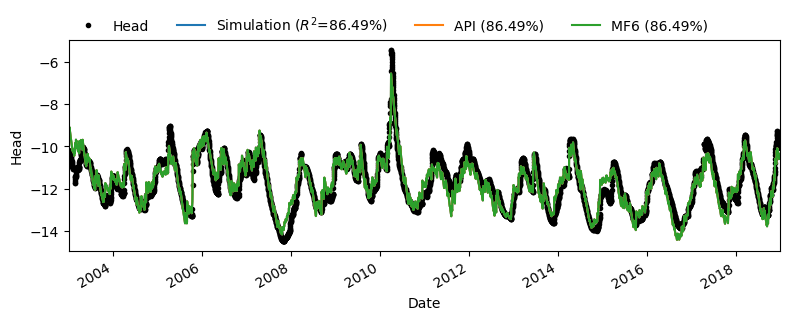

In [15]:
ax = ml3.plot(figsize=(8, 3))
sim1 = ml1.simulate()
ax.plot(sim1.index, sim1, label=f"API ({ml1.stats.rsq():.2%})")
sim2 = ml2.simulate()
ax.plot(sim2.index, sim2, label=f"MF6 ({ml2.stats.rsq():.2%})")
ax.legend(loc=(0, 1), frameon=False, ncol=4)

## MODFLOW API objects (for testing)

## MODFLOW with callback